In [1]:
%env WANDB_PROJECT=nlu_sentiment_analysis
!wandb login 2cad8a8279143c69ce071f54bf37c1f5a5f4e5ff
import wandb

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import requests, re, string, datetime, copy
from functools import partial

import torch
import torchvision.transforms as T, torch.nn.functional as F, torch.nn as nn

from datasets import Dataset
from transformers import TrainingArguments, EarlyStoppingCallback, TrainerCallback
from transformers import Trainer
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

PATH = "./data/Sentipolc16/"

env: WANDB_PROJECT=nlu_sentiment_analysis
wandb: Appending key for api.wandb.ai to your netrc file: /home/steve/.netrc


In [2]:
train = pd.read_csv(PATH + "training_set_sentipolc16.csv")
train.head()

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,122449983151669248,1,0,1,0,0,1,1,Intanto la partita per Via Nazionale si compli...
1,125485104863780865,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà Mario Monti..."
2,125513454315507712,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà #editoriale..."
3,125524238290522113,1,0,1,0,0,1,1,Mario Monti: Berlusconi risparmi all'Italia il...
4,125527933224886272,1,0,1,0,0,1,1,Mario Monti: Berlusconi risparmi all'Italia il...


In [3]:
file1 = open(PATH + "test_set_sentipolc16_gold2000.csv", 'r') 
Lines = file1.readlines()
 
test = []
for line in Lines:
  arr = line.split("\",")
  if len(arr) != 9:
    arr[8] = arr[8] + arr[9]  #to account for tweets containing the delimiter charachter that would create more splits than needed
    del arr[9:]
  for i in range(8):
    arr[i] = int(arr[i].strip("\""))
  test.append(arr)

test = pd.DataFrame(test, columns=train.columns)
test.head()

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,507074506880712705,0,0,0,0,0,0,2,"""Tra 5 minuti presentazione piano scuola del g..."
1,507075789456961536,1,1,0,0,1,0,2,"""\""@matteorenzi: Alle 10 appuntamento su http:..."
2,507077511902425088,1,0,1,0,0,1,2,"""#labuonascuola gli #evangelisti #digitali non..."
3,507079183315787777,0,0,0,0,0,0,2,"""Riforma scuola Tutto il discorso di Renzi su..."
4,507080190225563648,1,0,0,0,0,0,2,""".@matteorenzi @MiurSocial #labuonascuola bast..."


In [4]:
"""Tokenization classes for Italian AlBERTo models."""
import collections
import os


def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip("\n")
        vocab[token] = index
    return vocab

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'user', 'percent', 'money', 'phone', 'time', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag"},
    fix_html=True,  # fix HTML tokens

    unpack_hashtags=True,  # perform word segmentation on hashtags

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

class AlBERTo_Preprocessing(object):
    def __init__(self, do_lower_case=True, **kwargs):
        self.do_lower_case = do_lower_case

    def preprocess(self, text):
        if self.do_lower_case:
            text = text.lower()
        text = str(" ".join(text_processor.pre_process_doc(text)))
        text = re.sub(r'[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
        text = re.sub(r'^\s', '', text)
        text = re.sub(r'\s$', '', text)
        return text

a = AlBERTo_Preprocessing(do_lower_case=True)
s = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
b = a.preprocess(s)
print(b)

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
Reading english - 2grams ...


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...
<hashtag> il governo </hashtag> presenta le linee guida sulla scuola <hashtag> la buona scuola </hashtag> <url>


In [5]:
def k_steps_evidence(num_iterations, early_stopping_patience, training_args, net, training, testing, validating):
    np.random.seed(0)
    torch.manual_seed(0)

    keys = ["eval_loss", "eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
    metrics = { i: [] for i in keys}
    for i in range(num_iterations):        
        trainer = Trainer(
            model=net(3),
            args=training_args, 
            train_dataset=training.shuffle(seed=i), 
            eval_dataset=validating, 
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)] if early_stopping_patience is not None else None
        )
        trainer.train()
        res = trainer.evaluate(testing)
        for m in keys:
            metrics[m].append(res[m])

    for m in metrics.keys():
        print("{:18s}\t: {:.4} ± {:.4}".format(m, np.mean(metrics[m]), np.std(metrics[m])))

In [6]:
from transformers import AutoTokenizer, AutoModel

a = AlBERTo_Preprocessing(do_lower_case=True)
s: str = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
b = a.preprocess(s)

tok = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
pretrained_model = AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
tok.model_max_length = 128 #model.config.max_position_embeddings
tokens = tok.tokenize(b)
print(tokens)

['<', 'ha', '##shtag', '>', 'il', 'governo', '<', '/', 'ha', '##shtag', '>', 'presenta', 'le', 'linee', 'guida', 'sulla', 'scuola', '<', 'ha', '##shtag', '>', 'la', 'buona', 'scuola', '<', '/', 'ha', '##shtag', '>', '<', 'ur', '##l', '>']


In [7]:
def tokenize_function(examples):
    sa = tok(examples["text"], padding="max_length", truncation=True)
    return sa

def separate2united_labels(row):
    """
        Return a single scalar integer label associated to the polarity of the tweet.

        Negative -> 0
        Neutral  -> 1
        Positive -> 2
        Mixed    -> 3
    """
    if row["opos"] == 0 and row["oneg"] == 0:
        return 1
    elif row["oneg"] == 0 and row["opos"] == 1:
        return 2
    elif row["oneg"] == 1 and row["opos"] == 0:
        return 0
    else:
        return 3

#train set
dataset = pd.DataFrame({"text": train.text.apply(a.preprocess), "idx": train.index, "labels": train[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
X_train, X_val = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset["labels"])

X_train = Dataset.from_pandas(X_train)
X_val = Dataset.from_pandas(X_val)

training = X_train\
                    .map(tokenize_function, batched=True)\
                    .filter(lambda example: example['labels'] != 3)\
                    .shuffle(seed=42)\
                    .with_format("torch")
validating = X_val\
                    .map(tokenize_function, batched=True)\
                    .filter(lambda example: example['labels'] != 3)\
                    .with_format("torch")


#test set
dataset = pd.DataFrame({"text": test.text.apply(a.preprocess), "idx": test.index, "labels": test[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
dataset = Dataset.from_pandas(dataset)

testing = dataset\
                    .map(tokenize_function, batched=True)\
                    .filter(lambda example: example['labels'] != 3)\
                    .with_format("torch")

In [8]:
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score

class EarlyStopping():    
    def __init__(self, min_delta = 0, patience = 0):        
        self.min_delta = min_delta
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = -np.Inf
        self.stop_training = False
    
    def on_epoch_end(self, epoch, current_value):
        if np.greater((current_value - self.min_delta), self.best):
            self.best = current_value
            self.wait = 0
        else:
            self.wait += 1
            if self.wait > self.patience:
                self.stopped_epoch = epoch
                self.stop_training = True
        return self.stop_training


TRAIN_BATCH_SIZE = 64 
PREDICT_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 64 
WEIGHT_DECAY = 0.01
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3
MAX_SEQ_LENGTH = 128
WARMUP_PROPORTION = 0.1
num_train_steps = int(len(training) / TRAIN_BATCH_SIZE * NUM_EPOCHS)+1
NUM_WARMUP_STEPS =  int(num_train_steps * WARMUP_PROPORTION)
RUN_NAME = "test_trainer"

## Torch loop

In [9]:
class MyNetMC(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer with Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetMC, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)#AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()


    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        x = self.dropout1(outputs[1])
        logits = self.linear1(x)
        loss = self.loss_fct(logits, labels)
        return logits , loss
    
class MyNetMCTuned(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer without Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetMCTuned, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)
        self.linear = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        logits = self.linear(outputs[1])
        loss = self.loss_fct(logits, labels)
        return logits , loss

## Utility functions

In [10]:
from transformers import get_linear_schedule_with_warmup

device = "cuda:0"

def train_epoch(model, train_loader, optimizer, scheduler, epoch, logging):
    model.train()
    targets = []
    outputs = []
    cumulative_loss = 0.
    for i , data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):        
        targets.extend(data["labels"].numpy())
        
        batch = {k: v.to(device) for k, v in data.items()}
        logits , loss = model(**batch)

        cumulative_loss += loss.detach()
        if (i+1) % 25 == 0 and logging:
            print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
    #print("Cum_loss_opos = ", model.cum_loss_opos.item() / len(train_loader))
    #print("Cum_loss_oneg = ", model.cum_loss_oneg.item() / len(train_loader))
    #model.reset_cum_loss()
    if logging: wandb.log({"train": {'loss': cumulative_loss.item() / len(outputs)}})
    return outputs, targets
    
        
def validation_epoch(model, epoch, val_loader, kind, logging):
    model.eval()
    targets = []
    outputs = []
    cumulative_loss = 0.
    with torch.no_grad():
        for _, data in enumerate(val_loader, 0):
            #ids            = data['input_ids'].to(device, dtype = torch.long)
            #mask           = data['attention_mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            #targets        = data['labels'].to(device, dtype = torch.long)
            
            batch = {k: v.to(device) for k, v in data.items()}
            logits , loss = model(**batch)
            cumulative_loss += loss.detach()
            if (i+1) % 25 == 0 and logging:
                print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
            
            #outputs_opos , outputs_oneg , _ = model(input_ids=ids, attention_mask=mask, token_type_ids=token_type_ids, labels=targets)
            
            targets.extend(batch["labels"].cpu().detach().numpy())
            outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
    if logging: wandb.log({kind: {'loss': cumulative_loss.item() / len(outputs)}})
    return outputs, targets

## HPT

In [11]:
#%%script echo skipping
import optuna
from optuna.trial import TrialState

def objective(trial):
    model = MyNetMCTuned(3).to(device)

    # Generate the optimizers.
    lr = trial.suggest_float("learning_rate", 2e-6, 2e-4, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-1)
    warmup = trial.suggest_float("warmup_steps", 0., 0.9, step=0.3),
    optimizer = torch.optim.AdamW(model.parameters(),
                              lr=lr,
                              weight_decay=wd, 
                              eps=1e-6)

    early_stopping = EarlyStopping(min_delta=0.005, patience=3)

    train_loader = DataLoader(training.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), shuffle=True, batch_size=64)
    val_loader = DataLoader(validating.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), batch_size=64)

    num_epochs = 15
    num_train_steps = int(len(train_loader) * num_epochs) + 1
    NUM_WARMUP_STEPS =  int(num_train_steps * warmup[0])
    scheduler = get_linear_schedule_with_warmup(optimizer, NUM_WARMUP_STEPS, num_train_steps)

    logging = False
    
    best_val = 0
    for epoch in range(num_epochs):
        outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch, logging)
        #f1_train = f1_score(targets, outputs, average='macro')
        
        outputs, targets = validation_epoch(model, epoch, val_loader, "val", logging)
        f1_val = f1_score(targets, outputs, average='macro')
        
        if f1_val > best_val:
            best_val = f1_val
        if early_stopping.on_epoch_end(epoch, f1_val):
            print("\n\nEARLY STOPPING AFTER {} EPOCHS".format(epoch))
            break

        #print(f"Val F1 = {f1_val}")
        trial.report(f1_val, epoch)
        
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return best_val

## Training AlBERTo

In [12]:
np.random.seed(0)
torch.manual_seed(0)
model = MyNetMC(3).to(device)

best_hyper = {'learning_rate': LEARNING_RATE, 'warmup_steps': WARMUP_PROPORTION, 'weight_decay': WEIGHT_DECAY}

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=best_hyper["learning_rate"],
                              weight_decay=best_hyper["weight_decay"], 
                              eps=1e-6)

#train set
tmp = pd.DataFrame({"text": train.text.apply(a.preprocess), "idx": train.index, "labels": train[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
tmp = Dataset.from_pandas(tmp)
tmp = tmp\
                    .map(tokenize_function, batched=True)\
                    .filter(lambda example: example['labels'] != 3)\
                    .shuffle(seed=42)\
                    .with_format("torch")

train_loader = DataLoader(tmp.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), shuffle=True, batch_size=32)
test_loader = DataLoader(testing.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), batch_size=64)

num_epochs = NUM_EPOCHS
num_train_steps = int(len(train_loader) * num_epochs) + 1
NUM_WARMUP_STEPS =  int(num_train_steps * best_hyper["warmup_steps"])
scheduler = get_linear_schedule_with_warmup(optimizer, NUM_WARMUP_STEPS, num_train_steps)

logging = True
if logging:
    run = wandb.init(
      project='nlu_sentiment_analysis',
      name="AlBERTo-MC",
      entity='mcstewe',
      notes='',
      reinit=True,
      config=dict (
        epochs=num_epochs
      )
    )
    wandb.watch(model)

best_value = 0
for epoch in range(num_epochs):
    outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch, logging)
    f1_train = f1_score(targets, outputs, average='macro')
    
    print(f"Train F1 = {f1_train}")
    outputs, targets = validation_epoch(model, epoch, test_loader, "test", logging=False)
    f1_test = f1_score(targets, outputs, average='macro')
    print("Test F1=", f1_test)
    if logging:
        wandb.log({"train": {'f1': f1_train, "lr": optimizer.param_groups[0]['lr']}})
        wandb.log({"test": {'f1': f1_test}})
torch.save(model.state_dict(), "data/models/alberto_multiclass.pt")    
    
if logging:
    run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: mcstewe (use `wandb login --relogin` to force relogin)


Epoch: 0, Loss:  1.1672417322794597
Epoch: 0, Loss:  1.0900421142578125
Epoch: 0, Loss:  1.0311015361064189
Epoch: 0, Loss:  0.9622758807558002
Epoch: 0, Loss:  0.9175800200431578
Epoch: 0, Loss:  0.8827222785693687
Epoch: 0, Loss:  0.8574930826822916
Epoch: 0, Loss:  0.8370763884117854

Train F1 = 0.6079766420758286
Test F1= 0.6495411155124479


Epoch: 1, Loss:  0.5448492765426636
Epoch: 1, Loss:  0.5211755402234136
Epoch: 1, Loss:  0.5171999544710726
Epoch: 1, Loss:  0.5265656673546993
Epoch: 1, Loss:  0.5271656897760206
Epoch: 1, Loss:  0.5270108216560927
Epoch: 1, Loss:  0.5225905056657463
Epoch: 1, Loss:  0.5179984317952065

Train F1 = 0.7940278207062158
Test F1= 0.6731079617269323


Epoch: 2, Loss:  0.3633444309234619
Epoch: 2, Loss:  0.3372465639698262
Epoch: 2, Loss:  0.3342942933778505
Epoch: 2, Loss:  0.3259595235188802
Epoch: 2, Loss:  0.32822070583220453
Epoch: 2, Loss:  0.33242562313207846
Epoch: 2, Loss:  0.32413901405772944
Epoch: 2, Loss:  0.3237035550064777

Train F1 = 0.8797160224239929
Test F1= 0.6378024531237604


_runtime,203
_timestamp,1627482857
_step,8


_runtime,▁▁▁▄▅▅███
_timestamp,▁▁▁▄▅▅███
_step,▁▂▃▄▅▅▆▇█


              precision    recall  f1-score   support

    negative       0.85      0.51      0.64       734
     neutral       0.70      0.78      0.74       914
    positive       0.44      0.69      0.54       316

    accuracy                           0.67      1964
   macro avg       0.66      0.66      0.64      1964
weighted avg       0.71      0.67      0.67      1964



Text(0.5, 1.0, 'SENTIPOLC16 - AlBERToMC')

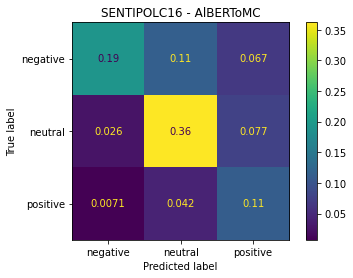

In [13]:
#load best model's params
model = MyNetMC(3).to(device)
model.load_state_dict(torch.load("data/models/alberto_multiclass.pt"))

preds , trues = validation_epoch(model, None, test_loader, "test", logging=False)

print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - AlBERToMC")

## Training AlBERTo validation set

In [14]:
np.random.seed(0)
torch.manual_seed(0)
model = MyNetMC(3).to(device)

best_hyper = {'learning_rate': LEARNING_RATE, 'warmup_steps': WARMUP_PROPORTION, 'weight_decay': WEIGHT_DECAY}

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=best_hyper["learning_rate"],
                              weight_decay=best_hyper["weight_decay"], 
                              eps=1e-6)

train_loader = DataLoader(training.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), shuffle=True, batch_size=32)
val_loader = DataLoader(validating.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), batch_size=64)
test_loader = DataLoader(testing.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), batch_size=64)

num_epochs = NUM_EPOCHS
num_train_steps = int(len(train_loader) * num_epochs) + 1
NUM_WARMUP_STEPS =  int(num_train_steps * best_hyper["warmup_steps"])
scheduler = get_linear_schedule_with_warmup(optimizer, NUM_WARMUP_STEPS, num_train_steps)

logging = True
if logging:
    run = wandb.init(
      project='nlu_sentiment_analysis',
      name="AlBERTo-MC-val",
      entity='mcstewe',
      notes='',
      reinit=True,
      config=dict (
        epochs=num_epochs
      )
    )
    wandb.watch(model)

best_value = 0
for epoch in range(num_epochs):
    outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch, logging)
    f1_train = f1_score(targets, outputs, average='macro')
    outputs, targets = validation_epoch(model, epoch, val_loader, "val", logging=False)
    
    f1_val = f1_score(targets, outputs, average='macro')
    if f1_val > best_value:
        best_value = f1_val
        torch.save(model.state_dict(), "data/models/alberto_multiclass_val.pt")    
    
    print(f"Val F1 = {f1_val}")
    outputs, targets = validation_epoch(model, epoch, test_loader, "test", logging=False)
    f1_test = f1_score(targets, outputs, average='macro')
    print("Test F1=", f1_test)
    if logging:
        wandb.log({"train": {'f1': f1_train, "lr": optimizer.param_groups[0]['lr']}})
        wandb.log({"val": {'f1': f1_val}})
        wandb.log({"test": {'f1': f1_test}})
    
if logging:
    run.finish()

Epoch: 0, Loss:  1.1712799866994221
Epoch: 0, Loss:  1.0679651377152424
Epoch: 0, Loss:  1.0052797472154773
Epoch: 0, Loss:  0.9508586845012627
Epoch: 0, Loss:  0.909255612281061
Epoch: 0, Loss:  0.8833399010984689
Epoch: 0, Loss:  0.8587818364987428

Val F1 = 0.7027370806947463
Test F1= 0.6254052521412569


Epoch: 1, Loss:  0.5450160503387451
Epoch: 1, Loss:  0.5507573497538664
Epoch: 1, Loss:  0.5418497034021326
Epoch: 1, Loss:  0.5457449248342803
Epoch: 1, Loss:  0.5376837945753529
Epoch: 1, Loss:  0.5340351898398176
Epoch: 1, Loss:  0.532709012086364

Val F1 = 0.6983327553153043
Test F1= 0.6899761719686611


Epoch: 2, Loss:  0.39226233959198
Epoch: 2, Loss:  0.36785460491569677
Epoch: 2, Loss:  0.3752712301305822
Epoch: 2, Loss:  0.36247661860302244
Epoch: 2, Loss:  0.3568246287684287
Epoch: 2, Loss:  0.35420068318411807
Epoch: 2, Loss:  0.3472936345242906

Val F1 = 0.7119154268155468
Test F1= 0.6629525495550136


_runtime,183
_timestamp,1627483053
_step,11


_runtime,▁▂▂▂▄▅▅▅▇███
_timestamp,▁▂▂▂▄▅▅▅▇███
_step,▁▂▂▃▄▄▅▅▆▇▇█


              precision    recall  f1-score   support

    negative       0.85      0.54      0.66       734
     neutral       0.70      0.82      0.76       914
    positive       0.50      0.68      0.57       316

    accuracy                           0.69      1964
   macro avg       0.68      0.68      0.66      1964
weighted avg       0.72      0.69      0.69      1964



Text(0.5, 1.0, 'SENTIPOLC16 - AlBERToMC val')

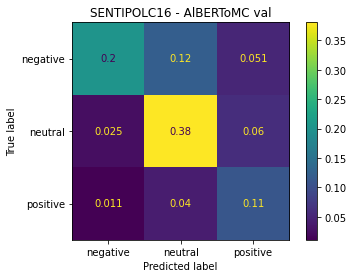

In [15]:
#load best model's params
model = MyNetMC(3).to(device)
model.load_state_dict(torch.load("data/models/alberto_multiclass_val.pt"))

preds , trues = validation_epoch(model, None, test_loader, "test", logging=False)

print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - AlBERToMC val")

## Training AlBERTo validation set + early stopping

In [16]:
np.random.seed(0)
torch.manual_seed(0)
model = MyNetMC(3).to(device)

best_hyper = {'learning_rate': LEARNING_RATE, 'warmup_steps': WARMUP_PROPORTION, 'weight_decay': WEIGHT_DECAY}

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=best_hyper["learning_rate"],
                              weight_decay=best_hyper["weight_decay"], 
                              eps=1e-6)

train_loader = DataLoader(training.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), shuffle=True, batch_size=32)
val_loader = DataLoader(validating.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), batch_size=64)
test_loader = DataLoader(testing.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), batch_size=64)

num_epochs = 15
num_train_steps = int(len(train_loader) * num_epochs) + 1
NUM_WARMUP_STEPS =  int(num_train_steps * best_hyper["warmup_steps"])
scheduler = get_linear_schedule_with_warmup(optimizer, NUM_WARMUP_STEPS, num_train_steps)
early_stopping = EarlyStopping(min_delta=0.005, patience=3)

logging = True
if logging:
    run = wandb.init(
      project='nlu_sentiment_analysis',
      name="AlBERTo-MC-val-early",
      entity='mcstewe',
      notes='',
      reinit=True,
      config=dict (
        epochs=num_epochs
      )
    )
    wandb.watch(model)

best_value = 0
for epoch in range(num_epochs):
    outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch, logging)
    f1_train = f1_score(targets, outputs, average='macro')
    outputs, targets = validation_epoch(model, epoch, val_loader, "val", logging=False)
    
    f1_val = f1_score(targets, outputs, average='macro')
    if f1_val > best_value:
        best_value = f1_val
        torch.save(model.state_dict(), "data/models/alberto_multiclass_val_early.pt")   
    if early_stopping.on_epoch_end(epoch, f1_val):
        print("\n\nEARLY STOPPING AFTER {} EPOCHS".format(epoch))
        break
    
    print(f"Val F1 = {f1_val}")
    outputs, targets = validation_epoch(model, epoch, test_loader, "test", logging=False)
    f1_test = f1_score(targets, outputs, average='macro')
    print("Test F1=", f1_test)
    if logging:
        wandb.log({"train": {'f1': f1_train, "lr": optimizer.param_groups[0]['lr']}})
        wandb.log({"val": {'f1': f1_val}})
        wandb.log({"test": {'f1': f1_test}})
    
if logging:
    run.finish()

Epoch: 0, Loss:  1.2345131238301594
Epoch: 0, Loss:  1.1411834249691086
Epoch: 0, Loss:  1.1024458601668075
Epoch: 0, Loss:  1.0697204898102115
Epoch: 0, Loss:  1.041627699329007
Epoch: 0, Loss:  1.013516419685927
Epoch: 0, Loss:  0.9802253986227101

Val F1 = 0.6686317008619516
Test F1= 0.5879855197717557


Epoch: 1, Loss:  0.690000851949056
Epoch: 1, Loss:  0.6775322738958864
Epoch: 1, Loss:  0.6683350124874631
Epoch: 1, Loss:  0.6740531536063763
Epoch: 1, Loss:  0.6742321137459047
Epoch: 1, Loss:  0.6683968665615824
Epoch: 1, Loss:  0.666448702757386

Val F1 = 0.7043895429086909
Test F1= 0.6696951477196876


Epoch: 2, Loss:  0.4457172155380249
Epoch: 2, Loss:  0.43172252421476404
Epoch: 2, Loss:  0.4375398996713999
Epoch: 2, Loss:  0.418652659714824
Epoch: 2, Loss:  0.41905996876378215
Epoch: 2, Loss:  0.42191662884398595
Epoch: 2, Loss:  0.41719335797189294

Val F1 = 0.6952758781234302
Test F1= 0.6282632185690321


Epoch: 3, Loss:  0.20192249615987143
Epoch: 3, Loss:  0.22299976738131777
Epoch: 3, Loss:  0.20574488510956634
Epoch: 3, Loss:  0.1952764530374546
Epoch: 3, Loss:  0.20137188511510049
Epoch: 3, Loss:  0.19925735780856754
Epoch: 3, Loss:  0.200122044004243

Val F1 = 0.6719427784564243
Test F1= 0.5958470073279017


Epoch: 4, Loss:  0.12693308790524802
Epoch: 4, Loss:  0.11382808490675322
Epoch: 4, Loss:  0.10991976712201093
Epoch: 4, Loss:  0.11067261358704229
Epoch: 4, Loss:  0.10642489310233824
Epoch: 4, Loss:  0.11058808653146629
Epoch: 4, Loss:  0.10781150028623383

Val F1 = 0.6896221052706455
Test F1= 0.65822544071392


Epoch: 5, Loss:  0.045173188050587974
Epoch: 5, Loss:  0.04322034485486089
Epoch: 5, Loss:  0.045195292782139136
Epoch: 5, Loss:  0.05122991523357353
Epoch: 5, Loss:  0.049474958450563496
Epoch: 5, Loss:  0.049493114420231556
Epoch: 5, Loss:  0.0536770765808807



EARLY STOPPING AFTER 5 EPOCHS


_runtime,352
_timestamp,1627483415
_step,20


_runtime,▁▁▁▁▂▃▃▃▄▄▄▄▅▅▅▅▇▇▇▇█
_timestamp,▁▁▁▁▂▃▃▃▄▄▄▄▅▅▅▅▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


              precision    recall  f1-score   support

    negative       0.86      0.53      0.66       734
     neutral       0.67      0.88      0.76       914
    positive       0.60      0.59      0.59       316

    accuracy                           0.70      1964
   macro avg       0.71      0.67      0.67      1964
weighted avg       0.73      0.70      0.69      1964



Text(0.5, 1.0, 'SENTIPOLC16 - AlBERToMC val+early')

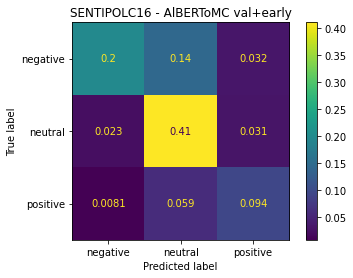

In [17]:
#load best model's params
model = MyNetMC(3).to(device)
model.load_state_dict(torch.load("data/models/alberto_multiclass_val_early.pt"))

preds , trues = validation_epoch(model, None, test_loader, "test", logging=False)

print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - AlBERToMC val+early")

## Training AlBERTo tuned + early stopping

#### run HPT to get the best hyper-parameters, then train the model

In [20]:
best_hyper = None

In [13]:
%%script echo skipping
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
best_hyper = trial.params
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

skipping


In [21]:
np.random.seed(0)
torch.manual_seed(0)
model = MyNetMCTuned(3).to(device)

if best_hyper is None:
    best_hyper = {'learning_rate': 3.000003529363845e-06, 'warmup_steps': 0.6, 'weight_decay': 0.000260393798851559}


# we will iterate through the layers of the network
#final_weights = []
#pretrained_weights = []
# for name, param in model.named_parameters():
#     if name.startswith('model'):
#         pretrained_weights.append(param)
#     else:
#         final_weights.append(param)
#optimizer = torch.optim.AdamW(params=[
#                                {'params': pretrained_weights, 'lr': 1e-5},
#                                {'params': final_weights, 'lr': 6e-5}],
#                              weight_decay=0.01, 
#                              eps=1e-6)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=best_hyper["learning_rate"],
                              weight_decay=best_hyper["weight_decay"], 
                              eps=1e-6)
early_stopping = EarlyStopping(min_delta=0.005, patience=3)


train_loader = DataLoader(training.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), shuffle=True, batch_size=32)
val_loader = DataLoader(validating.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), batch_size=64)
test_loader = DataLoader(testing.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), batch_size=64)

num_epochs = 15
num_train_steps = int(len(train_loader) * num_epochs) + 1
NUM_WARMUP_STEPS =  int(num_train_steps * best_hyper["warmup_steps"])
scheduler = get_linear_schedule_with_warmup(optimizer, NUM_WARMUP_STEPS, num_train_steps)

logging = False
if logging:
    run = wandb.init(
      project='nlu_sentiment_analysis',
      name="AlBERTo-MC-tuned",
      entity='mcstewe',
      notes='',
      reinit=True,
      config=dict (
        epochs=num_epochs
      )
    )
    wandb.watch(model)

best_value = 0
for epoch in range(num_epochs):
    outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch, logging)
    f1_train = f1_score(targets, outputs, average='macro')
    outputs, targets = validation_epoch(model, epoch, val_loader, "val", logging=False)
    
    f1_val = f1_score(targets, outputs, average='macro')
    if f1_val > best_value:
        best_value = f1_val
        torch.save(model.state_dict(), "data/models/alberto_multiclass_tuned.pt")    
    if early_stopping.on_epoch_end(epoch, f1_val):
        print("\n\nEARLY STOPPING AFTER {} EPOCHS".format(epoch))
        break
    
    print(f"Val F1 = {f1_val}")
    outputs, targets = validation_epoch(model, epoch, test_loader, "test", logging=False)
    f1_test = f1_score(targets, outputs, average='macro')
    print("Test F1=", f1_test)
    if logging:
        wandb.log({"train": {'f1': f1_train, "lr": optimizer.param_groups[0]['lr']}})
        wandb.log({"val": {'f1': f1_val}})
        wandb.log({"test": {'f1': f1_test}})
    
if logging:
    run.finish()


Val F1 = 0.2724485437545008
Test F1= 0.31124803732608974



Val F1 = 0.37721603956898075
Test F1= 0.4199889925125291



Val F1 = 0.46300888268758267
Test F1= 0.47188545099569407



Val F1 = 0.6107943483950645
Test F1= 0.590590089508691



Val F1 = 0.674694012949511
Test F1= 0.6444330196773654



Val F1 = 0.6877731600936868
Test F1= 0.6506429472373746



Val F1 = 0.6969663074800191
Test F1= 0.6813401256930449



Val F1 = 0.7042552748383276
Test F1= 0.6674615448729483



Val F1 = 0.7028982524637204
Test F1= 0.699602790663357



Val F1 = 0.7043223678478109
Test F1= 0.680325606225073



Val F1 = 0.7104462675822143
Test F1= 0.6679803148880493



Val F1 = 0.7121108164350799
Test F1= 0.6714469967540279



Val F1 = 0.7038949140870102
Test F1= 0.666467299283587



Val F1 = 0.7024560607824114
Test F1= 0.6629838853305716





EARLY STOPPING AFTER 14 EPOCHS


              precision    recall  f1-score   support

    negative       0.85      0.55      0.67       734
     neutral       0.70      0.85      0.76       914
    positive       0.53      0.63      0.58       316

    accuracy                           0.70      1964
   macro avg       0.69      0.68      0.67      1964
weighted avg       0.73      0.70      0.70      1964



Text(0.5, 1.0, 'SENTIPOLC16 - AlBERToMC tuned')

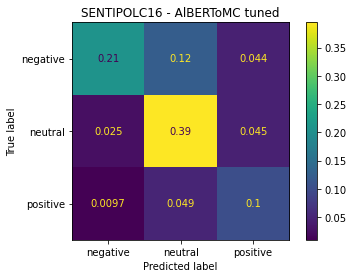

In [22]:
#load best model's params
model = MyNetMCTuned(3).to(device)
model.load_state_dict(torch.load("data/models/alberto_multiclass_tuned.pt"))

preds , trues = validation_epoch(model, None, test_loader, "test", logging=False)
print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - AlBERToMC tuned")

## FEEL-IT model test
Note that it was trained just for positive/negative class, so the neutral class is taken for examples with low confidence in the prediction.

In [11]:
device = "cuda:0"


              precision    recall  f1-score   support

    negative       0.61      0.89      0.72       734
     neutral       0.50      0.00      0.00       914
    positive       0.29      0.80      0.42       316

    accuracy                           0.46      1964
   macro avg       0.46      0.56      0.38      1964
weighted avg       0.50      0.46      0.34      1964



Text(0.5, 1.0, 'SENTIPOLC16 - Feel-it pretrained')

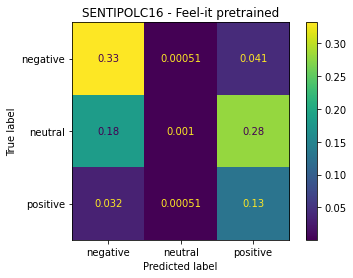

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def adapt_labels(example):
    if example["labels"] == 2: #positive class
        example["labels"] = 1
        return example
    return example #negative class


tok_feelit = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-sentiment")
tok_feelit.model_max_length = 128

model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-sentiment").to(device)
model.eval()

dataset = pd.DataFrame({"text": test.text.apply(a.preprocess), "idx": test.index, "labels": test[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
dataset = Dataset.from_pandas(dataset)
testing = dataset\
                .map(lambda examples: tok_feelit(examples["text"], padding="max_length", truncation=True), batched=True)\
                .filter(lambda example: example['labels'] != 3)\
                .with_format("torch")
test_loader = DataLoader(testing.with_format("torch", columns=["input_ids", "attention_mask", "labels"]), batch_size=64)


trues , preds , logitss = [] , [] , []
with torch.no_grad():
    for _, data in enumerate(test_loader, 0):
        batch = {k: data[k].to(device) for k in ['attention_mask', 'input_ids']}
        logits = model(**batch)[0]
        trues.extend(data["labels"].detach().numpy())
        preds.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
        logitss.extend(logits.cpu().detach().numpy().tolist()) #logits = logits.squeeze(0)
        
        
proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)

assert len(preds) == len(proba) and np.all(np.array((proba[:,1] + proba[:,0]) >= 0.99))
for i in range(len(proba)):
    if preds[i] == 1: #the net produces just [0,1] for positive/negative, so adjust label
        preds[i] = 2
    if max(proba[i,0] , proba[i, 1]) <= 0.55: #set to neutral  if the prediction's confidence is too low
        preds[i] = 1

print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))
cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - Feel-it pretrained")

In [24]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Histogram(x=proba[:,0], 
                           xbins=dict(
                            start=0.,
                            end=1.0,
                            size=0.1
                            ), 
                           histnorm='probability'))
fig.update_layout(
    title="Feel-it model's confidence distribution for Sentipolc16",
    xaxis_title="confidence",
    yaxis_title="normalized count",
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Histogram(x=proba[np.array(trues) == 1,0], 
                           xbins=dict(
                            start=0.,
                            end=1.0,
                            size=0.1
                            ), 
                           histnorm='probability'))
fig.update_layout(
    title="Feel-it model's confidence distribution for neutral tweets in Sentipolc16",
    xaxis_title="confidence",
    yaxis_title="normalized count",
)
fig.show()

0.4653767820773931